## Задание на программирование

**Выполнять задание следует с текущими значениями гиперпараметров. Для проверки ниже будут приведены ответы, которые должны получиться в результате выполнения задания. После того, как все ответы совпадут, можно будет использовать полученный блокнот для выполнения индивидуального задания.**

## Задание 5.2

В этом упражнении вам предстоит обучить агента взаимодействовать и побеждать в условиях не самой дружелюбной среды. Классически задача звучит следующим образом: агент с друзьями ранней весной играли в фрисби (летающая тарелка) на берегу прекрасного озера. В результате неудачного броска тарелка приземлилась на поверхности частично замерзшего озера. На озере есть участки с прочным льдом (белые квадраты) и участки с проталинами (черные квадраты). Задача агента — пройти от точки старта до точки падения тарелки (финиш), минуя проталины. Пример возможной конфигурации озера представлен на рисунке.

Агенту доступны четыре действия: влево, вверх, вправо и вниз. Игра заканчивается, если исчерпано количество шагов (в нашем случае это 100), агент проваливается под воду (черная клетка) или все же доходит до тарелки фрисби (финиш). В последнем случае он получает награду +1, во всех остальных случаях — награда равна нулю.

### Гиперпараметры модели

Выполните моделирование взаимодействия агента и среды. Для обучения используйте алгоритм **Q-обучения**. В качестве стратегии используйте $\epsilon$-жадную стратегию с параметром `epsilon = 0.05`. Коэффициент дисконтирования `gamma = 0.9`. Установите параметр `random_seed = 10`.

In [28]:
epsilon = 0.05 # Параметр эпсилон при использовании эпсилон-жадной стратегии
gamma = 0.9 # Коэффциент дисконтирования гамма
random_seed = 10 # Random seed

time_delay = 1 # Задержка времени при отрисовке процесса игры после обучения (секунды)
lr_rate = 0.9 # Коэффициент скорости обучения альфа

Импортируем библиотеки, создаем свою среду размера 6х6.

* S обозначает точку старта
* F -- лед безопасен
* H -- проталина
* G -- цель

Параметр `is_slippery=False` отвечает за условное отсутствие скольжения. То есть если агент выбрал действие пойти направо, то он переместится в соответствующее состояние. В общем случае из-за "скольжения" можно оказаться в другом состоянии.

Мы также скопировали из библиотки GYM и слегка модифицировали функцию `generate_random_map`, для того, чтобы генерировать произвольные карты на основе `random_seed`.





In [30]:
!git clone https://github.com/dvolchek/gym_0_18_0.git -q
%cd /content/gym_0_18_0
!pip install -e. -q
import gym
import numpy as np
import time
from IPython.display import clear_output


def generate_random_map(size, p, sd):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False
    np.random.seed(sd)

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0, 0))
        while frontier:
            r, c = frontier.pop()
            if not (r, c) in discovered:
                discovered.add((r, c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

#Генерация карты
random_map = generate_random_map(size=6, p=0.8, sd=random_seed) # Создаем свою карту
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) # Инициализируем среду
print("Ваша карта")
env.render() # Выводим карту на экран

fatal: destination path 'gym_0_18_0' already exists and is not an empty directory.
/content/gym_0_18_0
  Preparing metadata (setup.py) ... done
Ваша карта

SFFFFF
FFFFFH
FFHFFF
HFFFFF
FFFFFF
HFHFFG


Функции выбора действия и обновления таблицы ценности действий. Строчка *** используется для того, чтобы проверять ответы в openedx. Вне рамках академической задачи лучше использовать оригинальный метод класса `environment`, то есть:

`action = env.action_space.sample()`

# Задача 1
Дополните функцию ```learn()```, чтобы в результате ее вызова обновлялось значение ценности текущего действия согласно алгоритму Q-обучения



In [31]:
def choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, env.action_space.n) #***
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(state, state2, reward, action, done):
   if done:
      Q[state, action] = Q[state, action] + lr_rate * (reward - Q[state, action])
   else:
      Q[state, action] = Q[state, action] + lr_rate * (reward + gamma * np.max(Q[state2, :]) - Q[state, action])

# Задача 2
Дополните следующий код так, чтобы в результате обучения модели можно было узнать количество побед и номер игры (`game`), на котором агент впервые одержал пятую победу подряд.

Поясним, что возвращает функция ```env.step(action)```

```state2``` -- следующее состояние

```reward``` -- награда

```done``` -- флаг окончания игры. True в случае победы или падения в проталину. False в остальных случаях.




In [32]:
from tqdm import tqdm
# Inititalization
np.random.seed(random_seed)
total_games = 10000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))

wins_seq = []
fifth_win_game = 0

# Main cycle
for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    while t < max_steps:
        
        if game > 5 and wins_seq[game-5] == 1 and wins_seq[game-4] == 1 and wins_seq[game-3] == 1 and wins_seq[game-2] == 1 and wins_seq[game-1] == 1 and fifth_win_game == 0:
          fifth_win_game = game

        t += 1
        action = choose_action(state)
        state2, reward, done, info = env.step(action)

        if t == max_steps:
          done = True  

        learn(state, state2, reward, action, done)
        state = state2

        if done and reward == 1:
          wins_seq.append(1) # add win
          break
        if done:
          wins_seq.append(0) # add lose
          break

100%|██████████| 10000/10000 [00:14<00:00, 695.99it/s]


Вывод ответов при заданных параметрах

In [33]:
print("Количество побед в серии из 10 000 игр:", np.sum(wins_seq))
print("Пять побед подряд впервые было одержано в игре", fifth_win_game)


Количество побед в серии из 10 000 игр: 9678
Пять побед подряд впервые было одержано в игре 153


Должны получиться следующие результаты.


*  Количество побед в серии из 10 000 игр: 9678
*  Пять побед подряд впервые было одержано в игре 153




Произведем одну игру, чтобы проследить за действиями агента. При этом будем считать модель полностью обученной, то есть действия выбираются жадно, значения ценностей действий в таблице не обновляются.

In [34]:
import time

# Жадный выбор действий
def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

states = [] # Массив для сохранения состояний агента в течение игры
t = 0
state = env.reset()
wn = 0

while(t < 100):
  env.render()
  time.sleep(time_delay)
  clear_output(wait=True)
  action = choose_action_one_game(state)  
  state2, reward, done, info = env.step(action)  
  states.append(state)
  state = state2
  t += 1
  if done and reward == 1:
    wn = 1
  if done:
    break
if wn == 1:
  print("!!!Победа!!!")

!!!Победа!!!


Отобразим маршрут

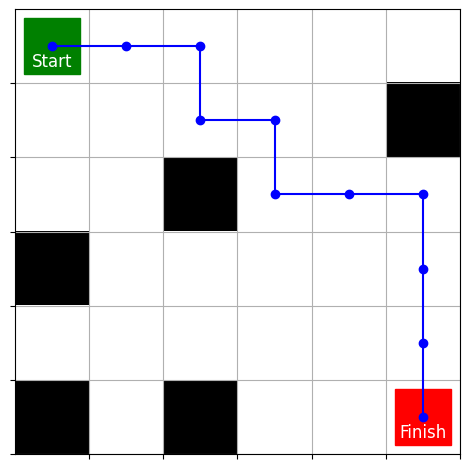

In [35]:
import matplotlib.pyplot as plt

def make_maze_pic(maze):
  maze_pic = []
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(0)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic

# Make maze fit to plot
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

# Arrays of picture elements
rw = np.remainder(states, nrows)
cl = np.floor_divide(states, nrows)
if wn == 1:
  rw = np.append(rw, [nrows-1])
  cl = np.append(cl, [ncols-1])

# Picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0], [0], "gs", markersize=40)  # Start is a big green square
ax1.text(0, 0.2, "Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1], [ncols-1], "rs", markersize=40)  # Exit is a big red square
ax1.text(nrows-1, ncols-1+0.2, "Finish", ha="center", va="center", color="white", fontsize=12) # Exit text
ax1.plot(rw, cl, ls = '-', color = 'blue') # Blue lines path
ax1.plot(rw, cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")